In [1]:
#!pip install spacy

In [2]:
#!python -m spacy download en

In [3]:
#!python -m spacy download en_core_web_sm

In [50]:
import pysrt
import numpy as np
import pandas as pd
import re
import os
import glob
from pathlib import Path
import spacy
from spacy.lang.en import stop_words

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    HalvingRandomSearchCV
)
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix,
    f1_score,
    classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool

import matplotlib.pyplot as plt
from pickle import dump

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
pd.set_option('display.max_rows', None)

In [7]:
random=1

In [8]:
tab_levels = pd.read_csv('./table_csv.csv')

In [9]:
tab_levels.Level.value_counts()

B2            101
B1             52
C1             40
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      4
Name: Level, dtype: int64

In [10]:
tab_levels.Level = tab_levels.Level.replace('A2/A2+', 'A2')
tab_levels.Level = tab_levels.Level.replace('A2/A2+, B1', 'B1')
tab_levels.Level = tab_levels.Level.replace('B1, B2', 'B2')

In [11]:
a2=glob.glob('/home/serenity/short/NLP_ENG/English_level/English_scores/Subtitles_all/A2/*.srt')
b1=glob.glob('/home/serenity/short/NLP_ENG/English_level/English_scores/Subtitles_all/B1/*.srt')
b2=glob.glob('/home/serenity/short/NLP_ENG/English_level/English_scores/Subtitles_all/B2/*.srt')
c1=glob.glob('/home/serenity/short/NLP_ENG/English_level/English_scores/Subtitles_all/C1/*.srt')
others=glob.glob('/home/serenity/short/NLP_ENG/English_level/English_scores/Subtitles_all/Subtitles/*.srt')

In [12]:
HTML = r'<.*?>' # html тэги меняем на пробел
UPPER = r'[[A-Za-z ]+[\:\]]' # указания на того кто говорит (BOBBY:)
TAG = r'{.*?}' # тэги меняем на пробел
COMMENTS = r'[\(\[][A-Za-z ]+[\)\]]' # комменты в скобках меняем на пробел
LETTERS = r'[^a-zA-Z\'.,!? ]' # все что не буквы меняем на пробел 
SPACES = r'([ ])\1+' # повторяющиеся пробелы меняем на один пробел
DOTS = r'[\.]+' # многоточие меняем на точку
SYMB = r"[^\w\d'\s]" # знаки препинания кроме апострофа


def clean_subs(subs):
    subs = subs[1:] # удаляем первый рекламный субтитр
    txt = re.sub(HTML, ' ', subs.text) # html тэги меняем на пробел
    txt = re.sub(UPPER, ' ', txt) # указания на того кто говорит (BOBBY:)
    txt = re.sub(COMMENTS, ' ', txt) # комменты в скобках меняем на пробел
    txt = re.sub(LETTERS, ' ', txt) # все что не буквы меняем на пробел
    txt = re.sub(DOTS, r'.', txt) # многоточие меняем на точку
    txt = re.sub(SPACES, r'\1', txt) # повторяющиеся пробелы меняем на один пробел
    txt = re.sub(SYMB, '', txt) # знаки препинания кроме апострофа на пустую строку
    txt = re.sub('www', '', txt) # кое-где остаётся www, то же меняем на пустую строку
    txt = txt.lstrip() # обрезка пробелов слева
    txt = txt.encode('ascii', 'ignore').decode() # удаляем все что не ascii символы   
    txt = txt.lower() # текст в нижний регистр
    return txt

In [13]:
fname = []
subtrs  = []
for i in c1:
    path = Path(i)
    name = path.stem
    subs = pysrt.open(i)
    text = clean_subs(subs)
    fname.append(name)
    subtrs.append(text)
df_c1 = pd.DataFrame({'Movie': fname, 'subtitles': subtrs, 'level': 'C1'}, 
                       columns=['Movie', 'subtitles', 'level'])
df_c1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Movie      33 non-null     object
 1   subtitles  33 non-null     object
 2   level      33 non-null     object
dtypes: object(3)
memory usage: 920.0+ bytes


In [14]:
def read_put(file, level):
    fname = []
    subtrs  = []
    for i in file:
        path = Path(i)
        name = path.stem
        subs = pysrt.open(i, encoding='cp1252')
        text = clean_subs(subs)
        fname.append(name)
        subtrs.append(text)
    return pd.DataFrame({'Movie': fname, 'subtitles': subtrs, 'level': level}, 
                       columns=['Movie', 'subtitles', 'level'])

In [15]:
df_a2 = read_put(a2, 'A2')
df_b1 = read_put(b1, 'B1')
df_b2 = read_put(b2, 'B2')
df_others = read_put(others, 'tab')

In [16]:
df_tab_new = df_others.merge(tab_levels, on='Movie', how='outer')

In [17]:
df_tab_new

,Movie,subtitles,level,Level
0,Hook(1991),because i couldn't get my shadow to stick besi...,tab,A2
1,Enola_Holmes(2020),the first thing you need to know is that my mo...,tab,B2
2,The_man_called_Flintstone(1966),when the chips are startin' to fall just when ...,tab,A2
3,The_graduate(1967),the sound you just heard is the landing gear l...,tab,B2
4,Logan(2017),we keep moving on no messing around you mess t...,tab,B1
5,Mary_Poppins_returns(2018),have come and gone through the misty morning s...,tab,B1
6,10_things_I_hate_about_you(1999),i'll be right with you so cameron here you go ...,tab,B1
7,Lion(2016),saroo come on come on get up come on quickly h...,tab,B2
8,The_Devil_Wears_Prad,hi i have an appointment with emily charlton a...,tab,B2
9,Oceans_Eleven(2001),man walking open gate two let's go face the wa...,tab,C1


In [18]:
df_tab_new = df_tab_new.drop(['level'], axis=1)

In [19]:
df_tab_new = df_tab_new.dropna(subset=['subtitles'])

In [20]:
df_tab_new.columns = ['Movie', 'subtitles', 'level']

In [21]:
df = pd.concat([df_a2, df_b1, df_b2, df_c1, df_tab_new], ignore_index=True)

In [22]:
df.loc[(df['Movie'] == 'Harry_Potter_and_the_philosophers_stone(2001)'), 'level'] = 'B1'
df.loc[(df['Movie'] == 'BrenВ.Brown.The.Call.to.Courage.2019.720.NF.720p.DDP.5.1.x264-CafeFlix'), 'level'] = 'B2'
level_A2 = (df['Movie'] == 'Casper') | (df['Movie'] == 'Up(2009)')
df.loc[level_A2, 'level'] = 'A2'
level_C1 = (df['Movie'] == 'The_Ghost_Writer') | (df['Movie'] == 'Pride_and_Prejudice')
df.loc[level_C1, 'level'] = 'C1'

In [23]:
df[df.level.isna()]

,Movie,subtitles,level
176,Westworld_scenes_of_Dr_Robert_Ford,no one's complained there's the lady with the ...,NaN
187,Breaking_Bad_The_Movie(2017),meet you sam working on anything you can talk ...,NaN
244,Gogo_Loves_English,so wow hello hello my name's tony what's your ...,NaN


In [24]:
df.level.value_counts()

B2    131
B1     56
C1     41
A2     33
Name: level, dtype: int64

In [25]:
df_no_level = df[df['level'].isna()].reset_index(drop=True)
df = df.dropna()

In [26]:
df.to_csv('./df_no_level.csv', index=False)

df_no_level

,Movie,subtitles,level
0,Westworld_scenes_of_Dr_Robert_Ford,no one's complained there's the lady with the ...,NaN
1,Breaking_Bad_The_Movie(2017),meet you sam working on anything you can talk ...,NaN
2,Gogo_Loves_English,so wow hello hello my name's tony what's your ...,NaN


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 263
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Movie      261 non-null    object
 1   subtitles  261 non-null    object
 2   level      261 non-null    object
dtypes: object(3)
memory usage: 8.2+ KB


In [28]:
df = df.sort_values(by='Movie').reset_index(drop=True)

In [29]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'tagger', 'ner'])

In [30]:
stops = nlp.Defaults.stop_words

In [31]:
def normalize(comment, remove_stopwords):
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

In [32]:
df['norm_subs'] = df['subtitles'].apply(normalize, remove_stopwords=True)

In [33]:
df.level.value_counts()

B2    131
B1     56
C1     41
A2     33
Name: level, dtype: int64

In [34]:
def search_best_estimator(pipeline, param_grid, x, y):
    hrs = HalvingRandomSearchCV(
        estimator=pipeline,
        param_distributions=param_grid,
        scoring='f1_weighted',
        cv=3,
        n_candidates="exhaust",
        factor=5,
        n_jobs=-1,
    )
    _ = hrs.fit(x, y)
    return hrs.best_estimator_

In [35]:
def plot_confusion_matrix(y_test, y_preds, model):
    fig, ax = plt.subplots(figsize=(16,10))
    cm = confusion_matrix(y_test, y_preds)
    cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
    cmp.plot(ax=ax)
    plt.show()

In [36]:
x, y = df['norm_subs'].tolist(), df['level'].tolist()

In [37]:
pipeline = Pipeline(
    steps = [("tfidf", TfidfVectorizer() ),("base",RandomForestClassifier() )]
)
param_grid = {
"tfidf__min_df": [i for i in range(15,35,5)],
"base__n_estimators": [i for i in range(100,500,50)],
"base__max_depth": [i for i in range(5,25)],
"base__min_samples_split":[i for i in range(2,8)]
}

In [38]:
estimator = search_best_estimator(pipeline, param_grid, x, y)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, random_state=random, test_size=0.25)

              precision    recall  f1-score   support

          A2       1.00      0.17      0.29         6
          B1       0.25      0.13      0.17        15
          B2       0.65      0.92      0.77        39
          C1       1.00      0.33      0.50         6

    accuracy                           0.62        66
   macro avg       0.73      0.39      0.43        66
weighted avg       0.63      0.62      0.56        66



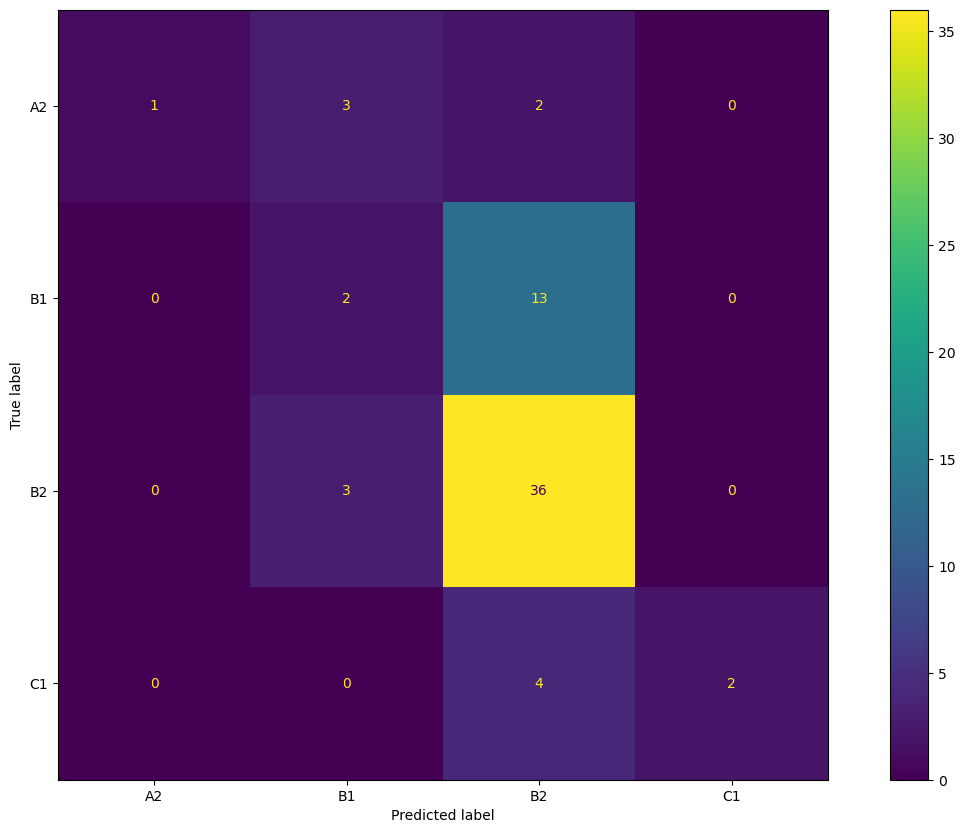

In [40]:
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)

print(classification_report(y_test, y_pred))

plot_confusion_matrix(y_test, y_pred, estimator)

In [41]:
logreg = Pipeline([
                ("tfidf", TfidfVectorizer() ),
                ('clf', LogisticRegression(n_jobs=1,C=1e5, solver='saga', 
                                           multi_class='multinomial',
                                           max_iter=1000,
                                           random_state=random)),
])

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          A2       1.00      0.33      0.50         6
          B1       0.44      0.47      0.45        15
          B2       0.78      0.90      0.83        39
          C1       1.00      0.50      0.67         6

    accuracy                           0.71        66
   macro avg       0.80      0.55      0.61        66
weighted avg       0.74      0.71      0.70        66



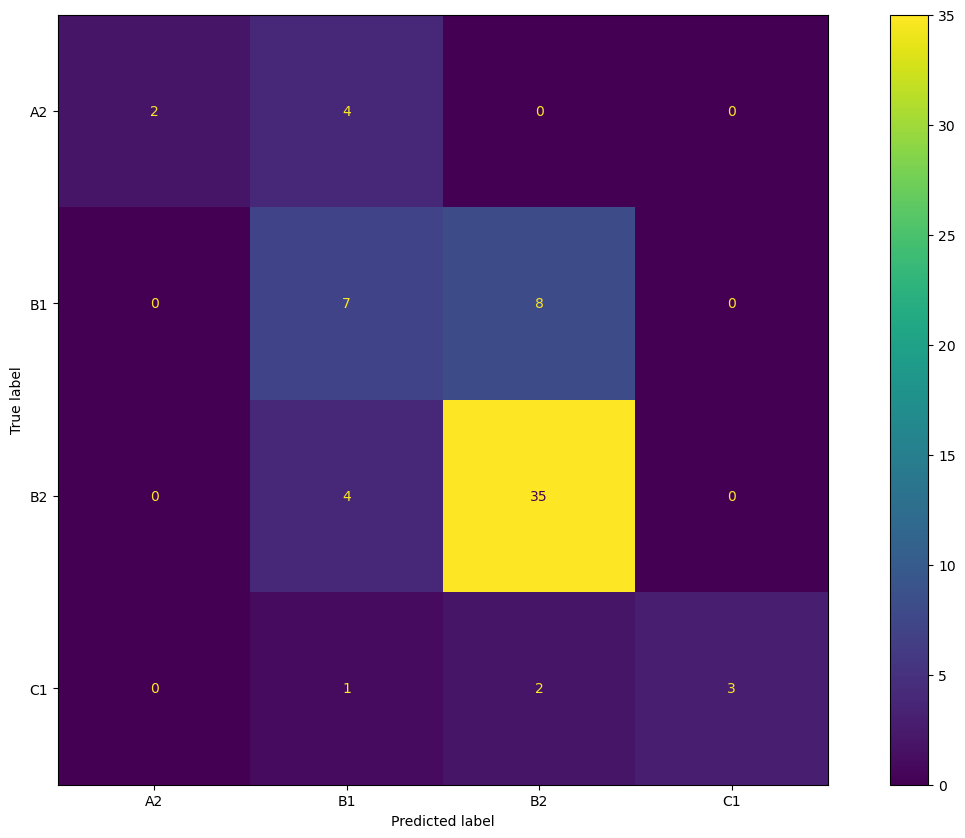

In [43]:
plot_confusion_matrix(y_test, y_pred, logreg)

In [44]:
def fit_model(train_pool, test_pool, **kwargs):
    model = CatBoostClassifier(iterations = 400,
                               eval_metric='TotalF1', od_type='Iter', 
                               od_wait=500, **kwargs)
    
    return model.fit(train_pool, eval_set=test_pool, 
                     verbose=100, plot=True, 
                     use_best_model=True)

In [45]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [46]:
train_pool = Pool(data=X_train, label=y_train)
valid_pool = Pool(data=X_test, label=y_test)

In [47]:
model = fit_model(train_pool, valid_pool, learning_rate=0.3,
                  dictionaries = [{
                      'dictionary_id':'Word',
                      'max_dictionary_size': '50000'
                  }],
                 feature_calcers = ['BoW:top_tokens_count=10000'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4369755	test: 0.4283892	best: 0.4283892 (0)	total: 3.88s	remaining: 25m 50s
100:	learn: 1.0000000	test: 0.5810825	best: 0.6115276 (18)	total: 1m 4s	remaining: 3m 10s
200:	learn: 1.0000000	test: 0.5836627	best: 0.6286895 (167)	total: 2m 8s	remaining: 2m 7s
300:	learn: 1.0000000	test: 0.6038961	best: 0.6286895 (167)	total: 3m 7s	remaining: 1m 1s
399:	learn: 1.0000000	test: 0.6015691	best: 0.6286895 (167)	total: 4m 4s	remaining: 0us

bestTest = 0.6286894923
bestIteration = 167

Shrink model to first 168 iterations.


In [48]:
cat_pred = model.predict(X_test)


print(classification_report(y_test,cat_pred))

              precision    recall  f1-score   support

          A2       0.40      0.33      0.36         6
          B1       0.57      0.27      0.36        15
          B2       0.69      0.92      0.79        39
          C1       1.00      0.33      0.50         6

    accuracy                           0.67        66
   macro avg       0.67      0.46      0.50        66
weighted avg       0.67      0.67      0.63        66



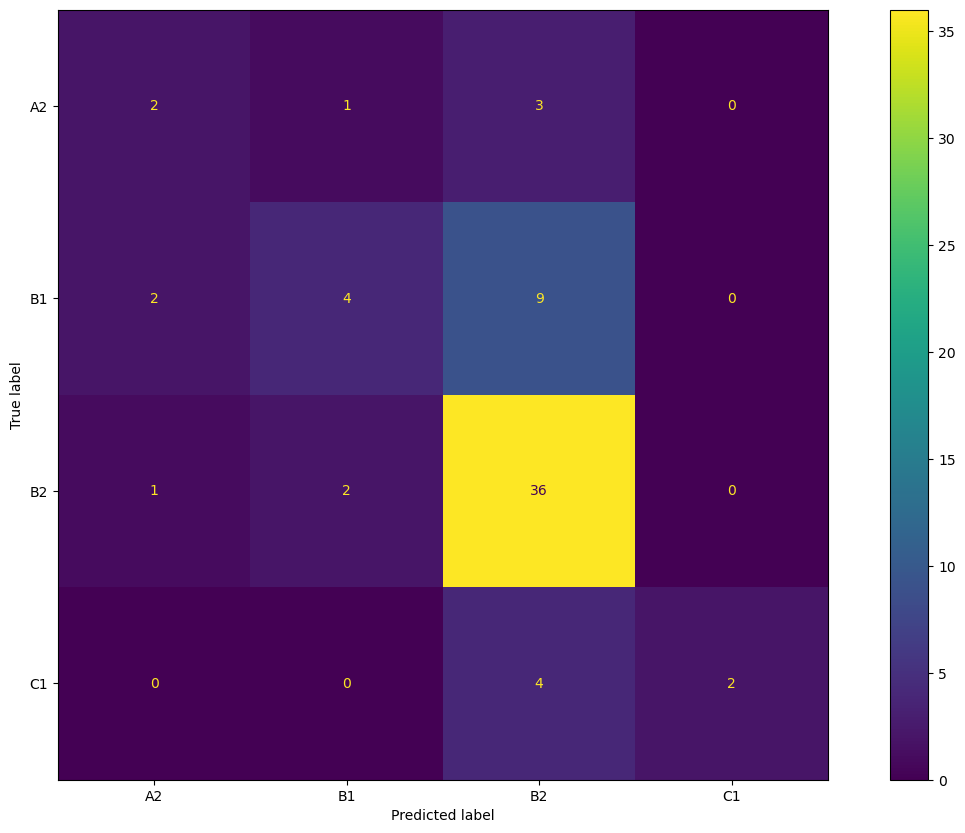

In [49]:
plot_confusion_matrix(y_test, cat_pred, model)

In [51]:
with open ('lmodel.pcl', "wb") as fid:
    dump(logreg, fid)